################################################################################################

***Description of notebook***  

This notebook showcases the demo of our solution (food nutrients tracker). 
- Takes in the User’s personal information (e.g. Age, Gender, Weight) and estimates recommended daily calorie intake.
- Take in freshly prepared food images, predict food label using the trained transformer model.
-- Use the predicted food classes to extract nutrition values from food_nutrition CSV file.
-- Tracks calories of Freshly Prepared Food consumed.
- Takes nutrient label image of packaged food, preprocesses image and extract the nutrition values.
-- Output nutrition information from nutrient label.
-- Tracks calories of Freshly Prepared Food consumed.

***Key functions***
- process_label_img(). —> preprocessing of nutrient label image.
- extract_text() —> Run OCR to extract text from pre-processed image.
- save_as_json() —> Save output from OCR as a temp JSON file.
- load_json_data() —> Load temp JSON file (output of OCR).
- extract_nutritional_info() —>  Create FIRST prompt and run gpt-3.5-turbo to interpret 
- extract_calories() —> Create SECOND prompt to run gpt3.5-turbo to specifically get standalone calories values.
- calculate_bmr(), calculate_calories() & select_goal() —> Input personal info (e.g. Age, Gender, Weight) of user & Weight management objective (e.g. maintain weight), estimate the daily recommended calories intake using formula.
- track_calories() —> Track calories of food images processed.
- Series of functions for Food Image Classifier. —> Main transformer model resides here.


***OUTPUT***
Nutritional information of fresh food images & nutrition labels of packaged food.
Recommended daily calories intake estimated.
Total calories consumed thus far in kcal & % of recommended daily intake.
Balance of calories budget remaining.


#### Note: This solution uses GPT API, re-run if there is an error.
If following error raised, re-run:  
ValueError: invalid literal for int() with base 10: 'The calories value per serving is 150.'

In [1]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import easyocr
from openai import OpenAI
import json

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Users/royyeo/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/royyeo/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/royyeo/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <6C61D832-88FC-351A-B596-B84F2E2D01B5> /Users/royyeo/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Define functions

In [2]:
###########################################################################
#                         Nutrition Label Extractor                       #
###########################################################################

### Set image path
# image_path = 'nl_1.jpg'
# image_path = 'nl_2.jpg'
# image_path = 'nl_3.jpg'


def process_label_img(image_path, verbose=False):

    # Load image
    image = cv2.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if verbose==True:
        plt.figure(figsize=(10, 10))
        plt.imshow(gray)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    if verbose==True:
        plt.figure(figsize=(10, 10))
        plt.imshow(blurred)

    # Detect edges
    edged = cv2.Canny(blurred, 50, 150)
    
    if verbose==True:
        plt.figure(figsize=(10, 10))
        plt.imshow(edged)

    # Find contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Variables to keep track of the largest contour
    largest_area = 0
    largest_contour = None

    for cnt in contours:
        # Approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        # Check if the approximated contour has four points
        if len(approx) == 4:
            area = cv2.contourArea(cnt)
            # Find the largest one
            if area > largest_area:
                largest_area = area
                largest_contour = approx

    if largest_contour is not None:
        # Draw the largest rectangle contour in green
        cv2.drawContours(image, [largest_contour], -1, (0, 255, 0), 3)

    if verbose==True:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        
    #     cv2.imshow('Detected Rectangles', image)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y+h, x:x+w]

    if verbose==True:
        plt.figure(figsize=(10, 10))
        plt.imshow(cropped_image)

    return cropped_image

################################################################
# cropped_image = process_label_img('nl_2.jpg') # sample
# cropped_image

In [3]:
################################################################
#                 Perform OCR to extract text                  #
################################################################

def extract_text(cropped_image):
    # Initialize the OCR reader 
    reader = easyocr.Reader(['en'], gpu=True)

    # Perform OCR on the image
    results = reader.readtext(cropped_image, paragraph=True)

    # Extract text and location
    text_results = [result[1] for result in results]
    locations = [result[0] for result in results]

    results
    text_results, locations
    
    return results

################################################################
# results = extract_text(cropped_image)
# results


In [4]:
### Save OCR results as a temp JSON file

def save_as_json(results):
        
    results_json = json.dumps(results)
    print(results_json)

    file_name = 'results.json'

    with open(file_name, 'w') as file:
        
        file.write(results_json)
        
        
################################################################
# save_as_json(results)

In [5]:
###########################################################################
#           Run GPT3.5 to map extract nutritional information             #
###########################################################################

# Set your OpenAI API key here
api_key = "your_key"
client = OpenAI(api_key=api_key)

# Load your JSON data
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Extract text from OCR data
def get_text_from_ocr(ocr_data):
    # Assuming all text is in a single string within the first item
    full_text = ocr_data[0]["text"] if ocr_data else ""
    return full_text

# Extract and process nutritional information using GPT-3.5
def extract_nutritional_info(full_text):
    

    # Generate a prompt for the model to interpret the text
    # prompt = f"Interpret this OCR output of a nutritional label and extract structured information: {full_text}"
    # prompt = f"Interpret this OCR output of a nutritional label and extract structured information (in Per Serving & Per 100g): {full_text}"
    # prompt = f"The JSON file provided contains nutritional information formatted in a single string, interpret and extract structured information (in Per Serving & Per 100g): {full_text}"
    prompt = f"The JSON file provided contains nutritional information formatted in a single string. Interpret and extract structured information in Per Serving & Per 100g if available: {full_text}"
    # prompt = f"The JSON file provided contains nutritional information formatted in a single string, interpret and extract structured infromation (in Per Serving & Per 100g if there is information). Output as dictionary: {full_text}"
    # Call the OpenAI API
    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        max_tokens=500
    )

    # Return the structured output
    return response.choices[0].text.strip()

def extract_calories(full_text):
    
    prompt = f"The JSON file provided contains nutritional information formatted in a single string, interpret and extract the calories values Per Serving. If it is not available, output the calories values Per 100g. Make sure to output just the value, without any other strings or symbols in the output!: {full_text}"

    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        max_tokens=500
    )

    return response.choices[0].text.strip()


#############################################################################
# Example usage
# if __name__ == "__main__":
#     # Load the OCR results from a JSON file
#     ocr_results = load_json_data("results.json")
#     # ocr_results = load_json_data("img1_results.json")
    
#     # Extract nutritional information
#     nutrition_info = extract_nutritional_info(ocr_results)
#     calorie_value = int(extract_calories(ocr_results))
    
#     print(nutrition_info)
#     print(f"{calorie_value} calories")

### RUN HERE:

In [6]:
##############################################################
#           Recommended Calories Intake Estimator            #
##############################################################

def calculate_bmr(weight, height, age, gender, body_fat=None):
    if body_fat is not None:
        # Katch-McArdle Formula (if body fat percentage is known)
        bmr = 370 + 21.6 * (1 - body_fat / 100) * weight
    elif gender.lower() == 'male':
        # Mifflin-St Jeor Equation for men
        bmr = 10 * weight + 6.25 * height - 5 * age + 5
    else:
        # Mifflin-St Jeor Equation for women
        bmr = 10 * weight + 6.25 * height - 5 * age - 161
    return bmr

def calculate_calories(age, gender, height, weight, activity, body_fat=None):
    activity_levels = {
        'sedentary': 1.2,
        'light': 1.375,
        'moderate': 1.55,
        'active': 1.725,
        'very active': 1.9,
        'extra active': 2.0
    }
    
    bmr = calculate_bmr(weight, height, age, gender, body_fat)
    maintenance_calories = bmr * activity_levels[activity.lower()]
    
    calorie_options = {
        'Maintain weight': maintenance_calories,
        'Mild weight loss (0.25 kg/week)': maintenance_calories - 250,
        'Weight loss (0.5 kg/week)': maintenance_calories - 500,
        'Extreme weight loss (1 kg/week)': maintenance_calories - 1000
    }
    return calorie_options

def select_goal(calorie_options):
    print("Please select your goal:")
    goals = list(calorie_options.keys())
    for i, goal in enumerate(goals, 1):
        print(f"{i}. {goal}")
    
    choice = int(input("Enter the number of your goal: "))
    selected_goal = goals[choice - 1]
    return selected_goal, calorie_options[selected_goal]

# Taking inputs from the user
age = int(input("Enter your age: "))
gender = input("Enter your gender (Male/Female): ")
height = float(input("Enter your height in cm: "))
weight = float(input("Enter your weight in kg: "))
activity = input("Enter your activity level (sedentary, light, moderate, active, very active, extra active): ")
body_fat_input = input("Enter your body fat percentage (optional, leave blank if unknown): ")
body_fat = float(body_fat_input) if body_fat_input else None

# # Sample user
# age = 28
# gender = "Male"
# height = 165
# weight = 65
# activity = 'extra active'
# body_fat_input = None
# body_fat = float(body_fat_input) if body_fat_input else None

calorie_options = calculate_calories(age, gender, height, weight, activity, body_fat)
goal, calories_needed = select_goal(calorie_options)
print(f"To {goal}, you should consume {calories_needed:.2f} calories per day.")

print(f"Recommended calories intake/day: {calories_needed}")



Please select your goal:
1. Maintain weight
2. Mild weight loss (0.25 kg/week)
3. Weight loss (0.5 kg/week)
4. Extreme weight loss (1 kg/week)
To Mild weight loss (0.25 kg/week), you should consume 1929.69 calories per day.
Recommended calories intake/day: 1929.6875


In [7]:
################################################################
#          Freshly Prepared Food Image Classification          #
################################################################
'''
Using Neural Network (NN) architecture to predict/classify food labels from images.
INPUT:  Freshly food image (simulate using image path)
OUTPUT: Predicted food class label (str)
'''

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50  # Change as per your model architecture
from PIL import Image
import torch.nn as nn
import pytorch_lightning as pl
from transformers import SwinForImageClassification, AutoFeatureExtractor
from torch.optim import AdamW
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

def predict_food_class(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
        ])
    
    class SwinTransformer(pl.LightningModule):
        def __init__(self, num_classes=20, learning_rate=1e-3):
            super().__init__()
            self.save_hyperparameters()

            self.feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")
            self.model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224")

            for param in self.model.parameters():
                param.requires_grad = False

            self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
            for param in self.model.classifier.parameters():
                param.requires_grad = True

            self.criterion = nn.CrossEntropyLoss()
            self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

        def forward(self, x):
            outputs = self.model(x).logits
            return outputs

        def training_step(self, batch, batch_idx):
            x, y = batch
            logits = self(x)
            loss = self.criterion(logits, y)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            self.log('train_acc', self.accuracy(logits, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
            return loss

        def validation_step(self, batch, batch_idx):
            x, y = batch
            logits = self(x)
            loss = self.criterion(logits, y)
            self.log('val_loss', loss, prog_bar=True)
            self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

        def test_step(self, batch, batch_idx):
            x, y = batch
            logits = self(x)
            loss = self.criterion(logits, y)
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_acc', self.accuracy(logits, y), prog_bar=True)
            return {'test_loss': loss, 'test_acc': self.accuracy(logits, y)}

        def configure_optimizers(self):
            optimizer = AdamW(self.model.classifier.parameters(), lr=self.hparams.learning_rate)
            return optimizer

    model = SwinTransformer.load_from_checkpoint(
    checkpoint_path='saved_models/checkpoints(Transformer)/best-checkpoint-epoch=04-val_loss=0.41(Swin).ckpt',
    model_name='deit_base_patch16_224'  
    )
    model.eval() 
    model = model.to('cpu')  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  
    model.to(device)  
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)  
    img = img.to(device)  

    with torch.no_grad():  
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)  

    label_names = {0:'ban_mian', 1:'chai_tow_kway', 2:'char_kway_teow', 3:'char_siew_rice', 4:'chicken_masala', 5:'chicken_rice', 6:'curry_puff', 7:'goreng_pisang', 8:'hokkien_prawn_mee', 9:'kway_chap', 10:'laksa', 11:'lotong_w_sayur_lodeh', 12:'mee_rebus', 13:'nasi_lemak', 14:'rojak', 15:'roti_john', 16:'roti_prata', 17:'satay', 18:'siew_mai', 19:'spring_roll'}

    # Load the image
    img = Image.open(image_path)  # Replace 'path_to_your_image.jpg' with the path to your image

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    return label_names[predicted.item()]

#############################################################################
# class_name = predict_food_class('data/chicken_rice/0J9QW66QX2JF28EIHTARPZQI.jpg')
# print('Predicted class name:', class_name)

'\nUsing Neural Network (NN) architecture to predict/classify food labels from images.\nINPUT:  Freshly food image (simulate using image path)\nOUTPUT: Predicted food class label (str)\n'

In [8]:
################################################################
#            Define function for tracking calories             #
################################################################

calories_counter = 0

def track_calories(calorie_input):
    global calories_counter  # Declare calories_counter as global
    
    calories_counter += calorie_input
    
    return calories_counter

# Example usage:
# calories_counter = track_calories(100)
# print("Total calories:", calories_counter)

c:\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


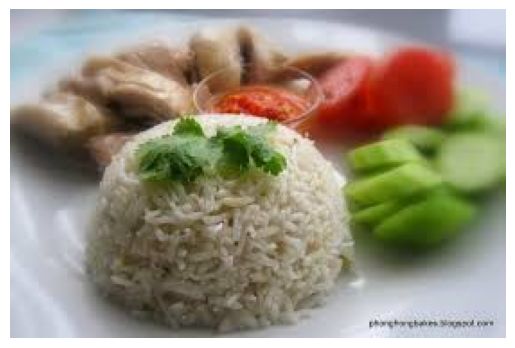

Predicted class name: chicken_rice


In [9]:
### Placeholder function for image classification checkpoint code.

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50  # Change as per your model architecture
from PIL import Image
import torch.nn as nn
import pytorch_lightning as pl
from transformers import SwinForImageClassification, AutoFeatureExtractor
from torch.optim import AdamW
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

def predict_food_class(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
        ])
    
    class SwinTransformer(pl.LightningModule):
        def __init__(self, num_classes=20, learning_rate=1e-3):
            super().__init__()
            self.save_hyperparameters()

            self.feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")
            self.model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224")

            for param in self.model.parameters():
                param.requires_grad = False

            self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
            for param in self.model.classifier.parameters():
                param.requires_grad = True

            self.criterion = nn.CrossEntropyLoss()
            self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

        def forward(self, x):
            outputs = self.model(x).logits
            return outputs

        def training_step(self, batch, batch_idx):
            x, y = batch
            logits = self(x)
            loss = self.criterion(logits, y)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            self.log('train_acc', self.accuracy(logits, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
            return loss

        def validation_step(self, batch, batch_idx):
            x, y = batch
            logits = self(x)
            loss = self.criterion(logits, y)
            self.log('val_loss', loss, prog_bar=True)
            self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

        def test_step(self, batch, batch_idx):
            x, y = batch
            logits = self(x)
            loss = self.criterion(logits, y)
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_acc', self.accuracy(logits, y), prog_bar=True)
            return {'test_loss': loss, 'test_acc': self.accuracy(logits, y)}

        def configure_optimizers(self):
            optimizer = AdamW(self.model.classifier.parameters(), lr=self.hparams.learning_rate)
            return optimizer

    model = SwinTransformer.load_from_checkpoint(
    checkpoint_path='saved_models/checkpoints(Transformer)/best-checkpoint-epoch=04-val_loss=0.41(Swin).ckpt',
    model_name='deit_base_patch16_224'  
    )
    model.eval() 
    model = model.to('cpu')  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  
    model.to(device)  
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)  
    img = img.to(device)  

    with torch.no_grad():  
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)  

    label_names = {0:'ban_mian', 1:'chai_tow_kway', 2:'char_kway_teow', 3:'char_siew_rice', 4:'chicken_masala', 5:'chicken_rice', 6:'curry_puff', 7:'goreng_pisang', 8:'hokkien_prawn_mee', 9:'kway_chap', 10:'laksa', 11:'lotong_w_sayur_lodeh', 12:'mee_rebus', 13:'nasi_lemak', 14:'rojak', 15:'roti_john', 16:'roti_prata', 17:'satay', 18:'siew_mai', 19:'spring_roll'}

    # Load the image
    img = Image.open(image_path)  # Replace 'path_to_your_image.jpg' with the path to your image

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    return label_names[predicted.item()]

class_name = predict_food_class('data/chicken_rice/0J9QW66QX2JF28EIHTARPZQI.jpg')
print('Predicted class name:', class_name)

Processing label: nl_1.jpg
[[[[19, 0], [744, 0], [744, 1259], [19, 1259]], "Nutrition Facts] About 5 servings per container Serving size 6 oz (170g) Amount per serving DIS Calories 150 Po % Daily Valuet Pas On \u20ac Total Fat 2g 3% Saturated Fat 1g 5% Trans Fat Og Cholesterol 1Omg_ 3% Sodium 85mg 4% Total Carbobydrate 279 10% Dietary  Fiber Og 0% 1 Total Sugars_ 20g Incl: 18g Added Sugars _ 36% Protein 6g u FlMtt T0h Vitamin D 10% Qur {Proue 2mcg_ 'Gul Calcium 15% '1003 [ 200mg  Iron Omg  0% Potassium 260m9 6% Vitamin A 15% 130mcg Te na % Daly  Value much nutient cal sening  dbod (DV) tels you how dait del 2000"]]
Per Serving:
- Serving size: 6 oz (170g)
- Calories: 150
- Total Fat: 2g
- Saturated Fat: 1g
- Trans Fat: 0g
- Cholesterol: 10mg
- Sodium: 85mg
- Total Carbohydrate: 27g
- Dietary Fiber: 0g
- Total Sugars: 20g (Includes 18g Added Sugars)
- Protein 6g
- Vitamin D: 10% DV
- Calcium: 15% DV
- Iron: 0% DV
- Potassium: 260mg
- Vitamin A: 15% DV 

Per 100g:
- Calories: 88.24
- Tot

ValueError: invalid literal for int() with base 10: 'The calories value per serving is 150.'

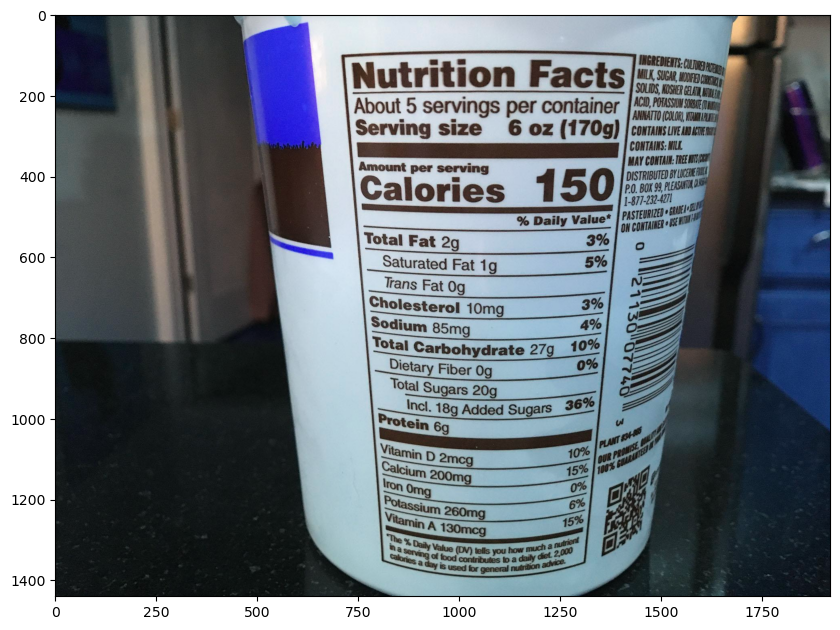

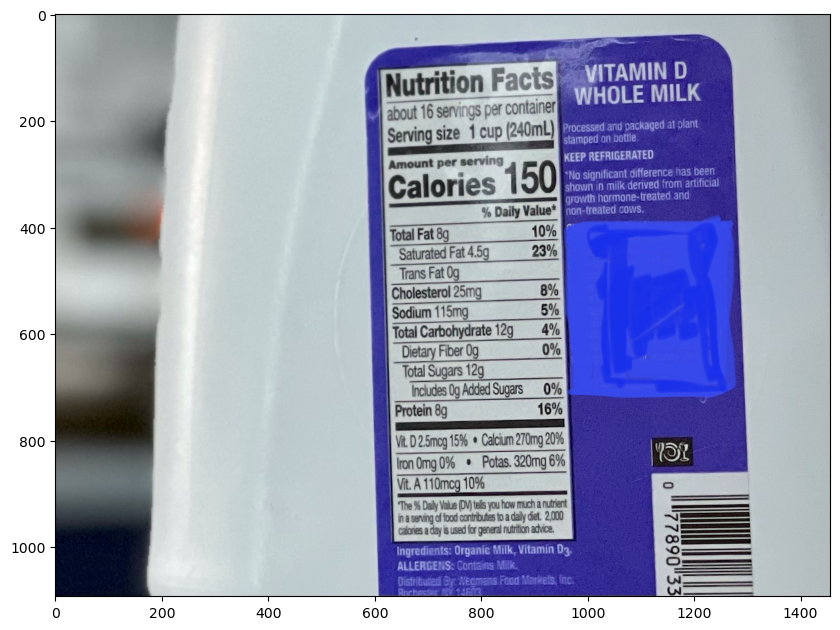

In [9]:
pd.set_option('display.max_rows', None)  # Show all rows

###################################################################
#                         Calories Tracker                        #
###################################################################

### Simulate user taking X number of photos of food nutrition labels

# List of label images.
labels_list = ['nl_1.jpg', 'nl_2.jpg', 'nl_3.jpg']
# labels_list = ['nl_2.jpg', 'nl_3.jpg']

# List of freshly prepared food images
# For brevity, only simulate with one freshly prepared food image.
food_list = ['0J9QW66QX2JF28EIHTARPZQI.jpg']


#####################################################################
#                   Packaged Food Nutrition Labels                  #
#####################################################################
# Initialise dictionary to track food calories
# calories_tracker_dict = {}

for label in labels_list:
    print("Processing label:", label)
    
    cropped_image = process_label_img(label)

    result = extract_text(cropped_image)

    save_as_json(result)
    
    if __name__ == "__main__":
        # Load the OCR results from a JSON file
        ocr_results = load_json_data("results.json")
        
        # Extract nutritional information
        nutrition_info = extract_nutritional_info(ocr_results)
        calorie_value = int(extract_calories(ocr_results))
        
        print(nutrition_info)
        print(f"{calorie_value} calories")
        
    
    ### Print 
    print(f"Calories of food consumed: {calorie_value}  ({round((calorie_value/ calories_needed)*100,2)}% of recommended daily intake)")
    
    print("="*100)
    print("="*100)
    
    print(f"Weight loss objective >>>      {goal}") #aq1
    print(f"Calories budget >>>        {calories_needed}")
    
    ### Track calories
    calories_counter = track_calories(calorie_value)
    print("Total calories consumed:", calories_counter)
    
    ### Compute calories consumed as % of recommended calorie intake (based on user demographc)
    print(f"Total calories consumed as % of recommended daily intake: {round((calories_counter/ calories_needed)*100,2)}%")
    
    ### Compute balance of calories to consume before exceeding recommended value.
    print(f"Amount of calories remaining to consume: {calories_needed - calories_counter}")


#####################################################################
#                       Freshly Prepared Food                       #
#####################################################################
### Load the freshly prepared food image

## Loop list of freshly prepared food to simulate user actions.
for fresh_food in food_list:

    ### Show food image & Run classifier model.
    class_name = predict_food_class('data/chicken_rice/0J9QW66QX2JF28EIHTARPZQI.jpg')
    print('Predicted class name of Food image:', class_name)

    
    ### With the predicted food label, look up food data csv to return 1) nutrition values 2) calorie value for tracking.
    # aq1
    ### Read food_nutrition.csv file.
    food_nutrition = pd.read_csv('food_nutrition.csv')
    food_nutrition_slice = food_nutrition[food_nutrition['food']==class_name]

    calorie_value = food_nutrition_slice['calories_kcal'].iloc[0]
    
    # Track calories
    calories_counter = track_calories(calorie_value)
    print("Total calories:", calories_counter)
    
    ### Print
    print(f"Calories of food consumed: {calorie_value}  ({round((calorie_value/ calories_needed)*100,2)}% of recommended daily intake)")
    
    ### Compute calories consumed as % of recommended calorie intake (based on user demographc)
    print(f"Total calories consumed as % of recommended daily intake: {round((calories_counter/ calories_needed)*100,2)}%")
    
    ### Compute balance of calories to consume before exceeding recommended value.
    print(f"Amount of calories remaining to consume: {calories_needed - calories_counter}")
    
#####################################################################
    